# Importing Packages

In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Preprocessing

In [2]:
data_dir = pathlib.Path('C:/Users/Blake/Downloads/Shoes Dataset') # defining the path to the dataset

In [3]:
# splitting the dataset into training set using TensorFlow's preprocessing function
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, # 80% of the data will be used for training
    subset = 'training',
    seed = 123, # ensures random partitioning
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 64 # images to be processed at a time
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2, # 20% of the data will be used for validating
    subset = 'validation',
    seed = 123, # having the same random seed ensures samples don't appear in both sets
    label_mode = 'categorical',
    image_size = (224, 224),
    batch_size = 64 # images to be processed at a time
)

Found 9280 files belonging to 5 classes.
Using 7424 files for training.
Found 9280 files belonging to 5 classes.
Using 1856 files for validation.


# Model Architecture

In [4]:
class_labels = training_set.class_names # getting the class labels of the dataset

In [5]:
mobilenet_model = Sequential() # creating a sequential model

# loading a pre-trained MobileNetV2 model
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top = False, # excluding the final classification layer of the original model
    input_shape = (224, 224, 3), # expected input image shape (224x224 pixels and 3 colour schemes - RGB)
    pooling = 'avg', # global average pooling layer for feature aggregation
    classes = len(class_labels), # number of output classes to be expected
    weights = 'imagenet' # initialise the pre-trained weights from the ImageNet dataset
)

# setting all layers in the pre-trained model to be non-trainable helps reduce training time
for layer in pretrained_model.layers:
    layer.trainable = False

mobilenet_model.add(pretrained_model) # adding the pre-trained MobileNetV2 model to the custom sequential model
mobilenet_model.add(Flatten()) # transforms the 2D feature maps to a 1D vector
mobilenet_model.add(Dense(512, activation = 'relu')) # add 512 neurons and ReLU activation for feature transformation
mobilenet_model.add(Dense(len(class_labels), activation = 'softmax')) # add a neuron for each output class and softmax activation for classification

In [6]:
# compile the model
mobilenet_model.compile(
    optimizer = Adam(learning_rate = 0.001), # Adam optimiser and a learning rate of 0.001 for gradient descent
    loss = 'categorical_crossentropy', # compile the model with the categorical cross entropy loss function for multi-class classification
    metrics = ['accuracy'] # compile the model with the accuracy metric to monitor performance during training
)

# Fine-Tuning Model

In [7]:
# fine-tune the model and store training history
history = mobilenet_model.fit(
    training_set,
    validation_data = validation_set,
    epochs = 10 # run over the training and validation sets 10 times
)

Epoch 1/10
116/116 [==============================] - 392s 3s/step - loss: 0.2686 - accuracy: 0.9108 - val_loss: 0.0613 - val_accuracy: 0.9844
Epoch 2/10
116/116 [==============================] - 454s 4s/step - loss: 0.0549 - accuracy: 0.9856 - val_loss: 0.0664 - val_accuracy: 0.9774
Epoch 3/10
116/116 [==============================] - 454s 4s/step - loss: 0.0275 - accuracy: 0.9934 - val_loss: 0.0246 - val_accuracy: 0.9919
Epoch 4/10
116/116 [==============================] - 455s 4s/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.0211 - val_accuracy: 0.9935
Epoch 5/10
116/116 [==============================] - 421s 3s/step - loss: 0.0117 - accuracy: 0.9981 - val_loss: 0.0203 - val_accuracy: 0.9925
Epoch 6/10
116/116 [==============================] - 424s 4s/step - loss: 0.0074 - accuracy: 0.9989 - val_loss: 0.0235 - val_accuracy: 0.9914
Epoch 7/10
116/116 [==============================] - 401s 3s/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 0.0110 - val_accuracy: 0.9962

# Model Evaluation

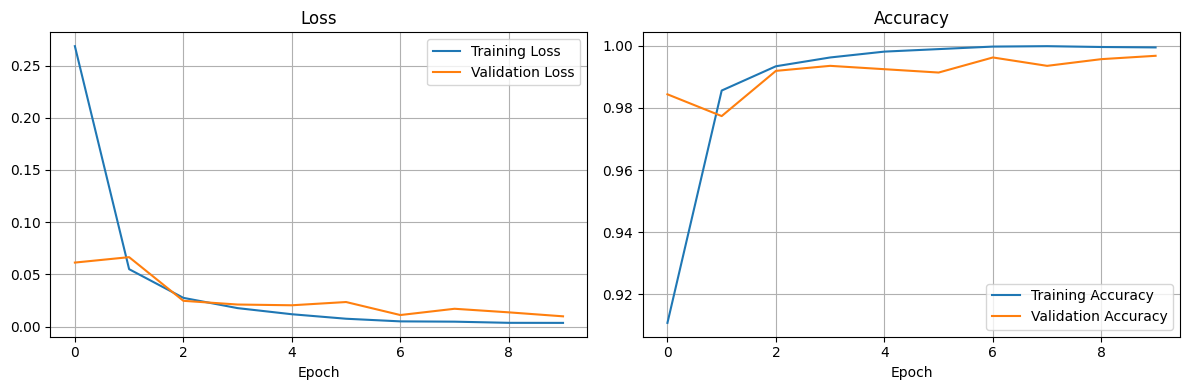

In [8]:
# accessing the history object to get loss and accuracy values across each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# creating subplots for loss and accuracy metrics
plt.figure(figsize = (12, 4))

# plotting training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid(True)

# plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)

# displaying the plots
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 36ms/step


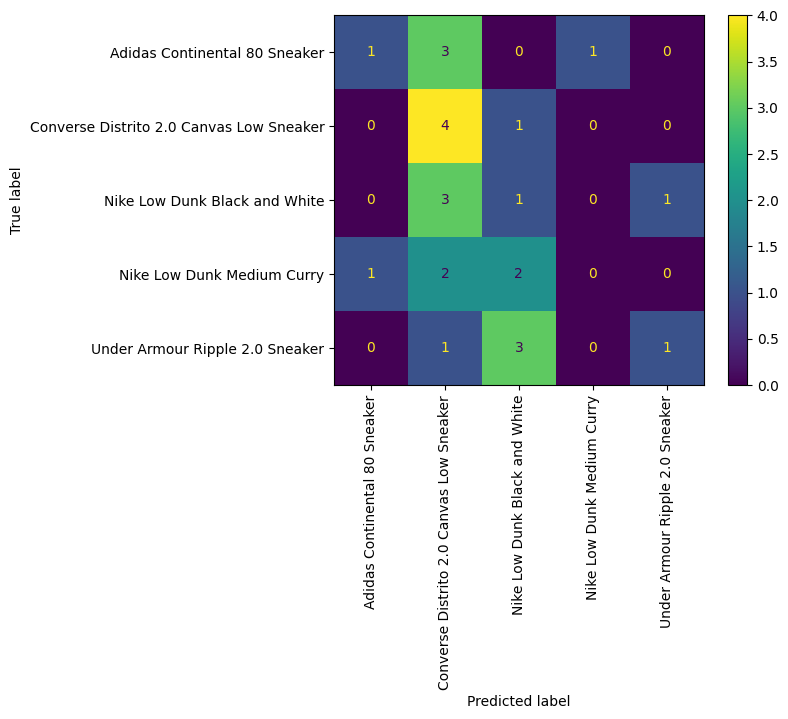

In [10]:
# initialising lists to store true and predicted labels
true_labels = []
predicted_labels = []

# defining the path to the test images
test_dir = 'C:/Users/Blake/Downloads/Shoes Test'

# mapping the test image prefixes to actual class labels
class_mapping = {
    'A': 'Adidas Continental 80 Sneaker',
    'C': 'Converse Distrito 2.0 Canvas Low Sneaker',
    'NBW': 'Nike Low Dunk Black and White',
    'NC': 'Nike Low Dunk Medium Curry',
    'UA': 'Under Armour Ripple 2.0 Sneaker'
}

# loop through each image in the test directory
for filename in os.listdir(test_dir):
    if filename.endswith('.JPG'):
        # load and preprocess image
        image = cv2.imread(os.path.join(test_dir, filename))
        image_resized = cv2.resize(image, (224, 224))
        image = np.expand_dims(image_resized, axis = 0)

        # make prediction
        prediction = mobilenet_model.predict(image)
        predicted_class = class_labels[np.argmax(prediction)]

        # extract the true class label from the filename
        prefix = filename.split('_')[0]
        true_class = class_mapping.get(prefix, 'Unknown')

        # append the true and predicted labels to the lists
        true_labels.append(true_class)
        predicted_labels.append(predicted_class)

# creating a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels = class_labels)

# displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
disp.plot(cmap = 'viridis', xticks_rotation = 'vertical')
plt.show()

# Exporting Model

In [11]:
# saving the Mobilenet model in Keras SavedModel format
mobilenet_model.save('MobileNet_5_shoes')

INFO:tensorflow:Assets written to: MobileNet_5_shoes\assets


INFO:tensorflow:Assets written to: MobileNet_5_shoes\assets


In [ ]:
# converting the Keras model to TensorFlow Lite (TFLite) format
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_model)
tflite_mobilenet_model = converter.convert()

# saving the TFLite model to a file
with open ('MobileNet_5_shoes.tflite', 'wb') as f:
  f.write(tflite_mobilenet_model)